In [ ]:
# Supplementary Figure 4.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, t
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.multitest import multipletests
from adjustText import adjust_text  # Adjust text to avoid overlapping

In [20]:

# load data to use in analysis

df_npq =  pd.read_excel("Supplementary_Dataset.xlsx", sheet_name="NPQ_and_SIMOA_Data")


In [21]:
# Build mapping dict for Mapping Target Names to be used in paper
df_target_names = pd.read_excel("Supplementary_Dataset.xlsx", sheet_name="Target Name")
mapping = dict(zip(df_target_names["Target Name on NULISAseq™ CNS Disease Panel "], df_target_names["Target Name used in the paper"]))

# Rename columns
df = df_npq.rename(columns=mapping)

In [22]:
# drop markers that were not used in t-test analysis
df = df.drop(columns=["Apo-E4", # Drop APOE4 (binary data) from t-test analysis;
                        "Simoa NfL log2(pg/mL)", "Simoa NfL (pg/mL)", "Simoa GFAP log2(pg/mL)", "Simoa GFAP (pg/mL)", # Drop repeat Simoa Data;
                        "PTN", "GDI-1", "Beta-synuclein"]) # Exclude nulisa markers from analysis which did not meet detectability cut-off;



In [23]:


# Define variables
group_col = "Group"
control_label = "Control"
disease_label = "MND"
alpha = 0.05

# Detect numeric marker columns
marker_cols = df.select_dtypes(include=[np.number]).columns.drop(group_col, errors="ignore")

# Split groups
df_control = df[df[group_col] == control_label]
df_disease = df[df[group_col] == disease_label]

power_calc = TTestIndPower()
results = []

for marker in marker_cols:
    values_disease = pd.to_numeric(df_disease[marker], errors="coerce").dropna().astype(float)
    values_control = pd.to_numeric(df_control[marker], errors="coerce").dropna().astype(float)

    n1 = len(values_disease)
    n2 = len(values_control)

    if n1 < 2 or n2 < 2:
        results.append({
            "marker": marker, "n_disease": n1, "n_control": n2, "mean_disease": np.nan,
            "mean_control": np.nan, "cohen_d": np.nan, "p_value": np.nan, "ci_lower": np.nan,
            "ci_upper": np.nan, "power": np.nan
        })
        continue

    mean_disease = values_disease.mean()
    mean_control = values_control.mean()
    std_disease = values_disease.std(ddof=1)
    std_control = values_control.std(ddof=1)

    # Cohen's d calculation
    pooled_sd = np.sqrt(((n1 - 1) * std_disease**2 + (n2 - 1) * std_control**2) / (n1 + n2 - 2))
    cohen_d = (mean_disease - mean_control) / pooled_sd if pooled_sd != 0 else np.nan

    # Power calculation
    power = power_calc.power(effect_size=np.abs(cohen_d), nobs1=n1, alpha=alpha, ratio=n2/n1, alternative='two-sided') if not np.isnan(cohen_d) else np.nan

    # T-test
    t_stat, p_value = ttest_ind(values_disease, values_control)

    # Confidence interval for mean difference
    mean_diff = mean_disease - mean_control
    se_diff = np.sqrt(std_disease**2 / n1 + std_control**2 / n2)
    df_welch = (std_disease**2 / n1 + std_control**2 / n2)**2 / \
               ((std_disease**2 / n1)**2 / (n1 - 1) + (std_control**2 / n2)**2 / (n2 - 1))
    ci_low = mean_diff - t.ppf(1 - alpha / 2, df_welch) * se_diff
    ci_high = mean_diff + t.ppf(1 - alpha / 2, df_welch) * se_diff

    results.append({
        "marker": marker, "n_disease": n1, "n_control": n2, "mean_disease": mean_disease,
        "mean_control": mean_control, "cohen_d": cohen_d, "p_value": p_value,
        "ci_lower": ci_low, "ci_upper": ci_high, "power": power
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Adjust p-values (FDR BH)
valid_p_mask = results_df["p_value"].notna()
rejected, pvals_corrected, _, _ = multipletests(results_df.loc[valid_p_mask, "p_value"], alpha=alpha, method="fdr_bh")
results_df.loc[valid_p_mask, "p_adj"] = pvals_corrected
results_df["significant"] = False
results_df.loc[valid_p_mask, "significant"] = rejected

# Sort by adjusted p-value
results_df = results_df.sort_values(by="p_adj", na_position="last")

# Save to CSV
results_df.to_csv("marker_results_with_power.csv", index=False)
print("Results saved to marker_results_with_power.csv")




Results saved to marker_results_with_power.csv


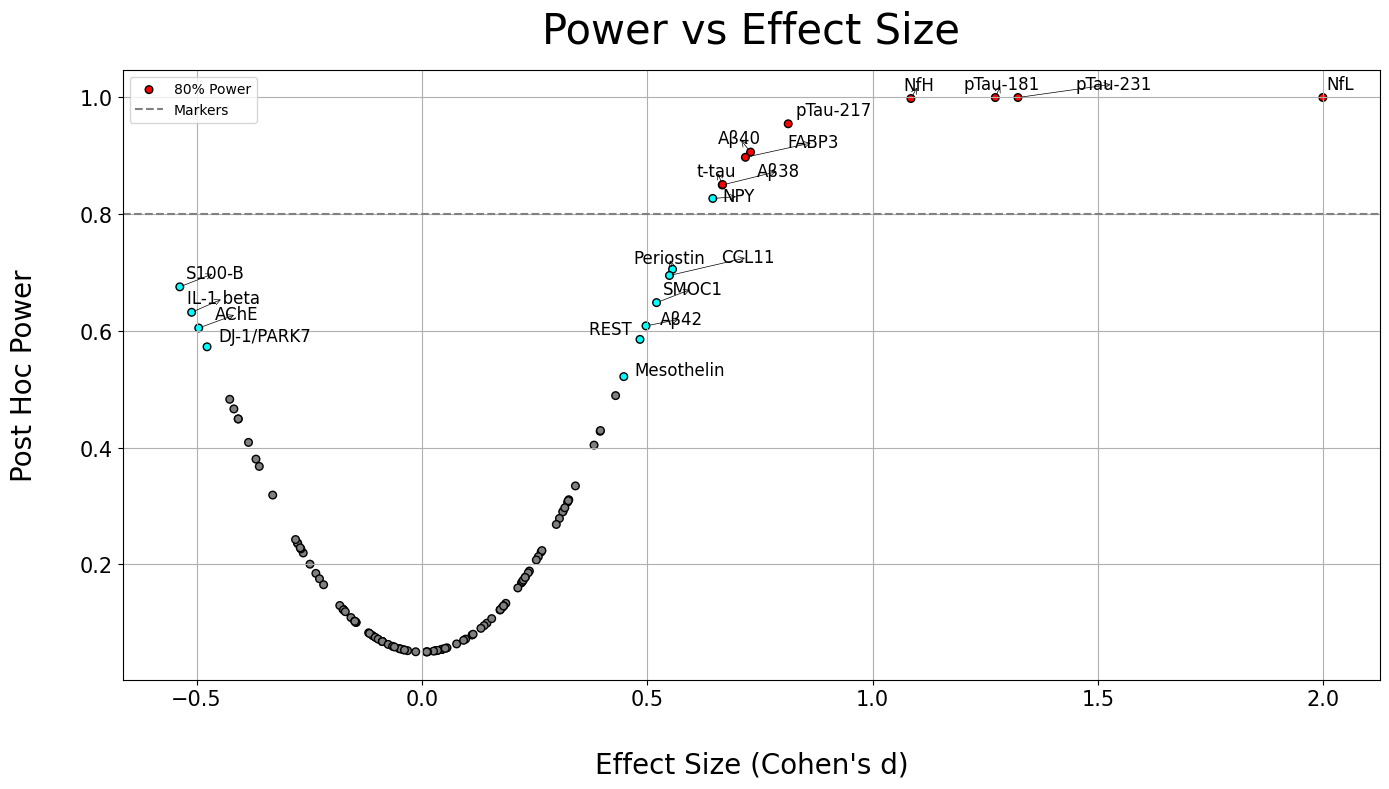

In [35]:

# Plotting
plt.figure(figsize=(14, 8))
colors = ["red" if row["p_adj"] < 0.05 else "cyan" if row["p_value"] < 0.05 else "gray" for _, row in results_df.iterrows()]

plt.scatter(results_df["cohen_d"], results_df["power"], c=colors, edgecolor="k", s=30)

texts = []
for _, row in results_df.iterrows():
    if (row["power"] > 0.8) or (row["p_value"] < 0.05 and (pd.isna(row["p_adj"]) or row["p_adj"] >= 0.05)):
        texts.append(plt.text(row["cohen_d"], row["power"], row["marker"], fontsize=12, ha="left", va="bottom"))

adjust_text(
    texts, arrowprops=dict(arrowstyle="<-", color='black', lw=0.5), force_points=3.5, force_text=2.5,
    expand_points=(6.3, 6.5), expand_text=(1.2, 2.0), only_move={'points': 'y', 'text': 'x'}
)

plt.xlabel("Effect Size (Cohen's d)", fontsize = 20, labelpad= 30)
plt.ylabel("Post Hoc Power", fontsize = 20, labelpad=30)
plt.title("Power vs Effect Size", fontsize = 30, pad = 20)
plt.xticks(fontsize=15)  # Rotate x-ticks vertically
plt.yticks(fontsize=15)   # Rotate y-ticks vertically
plt.axhline(y=0.8, color="gray", linestyle="--", label="80% Power Threshold")
plt.legend(["80% Power", "Markers"])
plt.grid(True)
plt.tight_layout()
plt.savefig(".\\figures\\power_vs_effect_size.png", dpi=300)
plt.show()


